# Tomo Challenge Sandbox

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tomo_challenge as tc

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


In [31]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import jax_cosmo.sparse as sparse

In [18]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


## Challenge Data

Specify options for loading the data:

In [4]:
bands='riz'
include_colors=True
include_errors=True

Load the training data:

In [7]:
training_file=f'/media/data2/tomo_challenge_data/ugrizy/training.hdf5'
train_data_arr = tc.load_data(training_file, bands, 
                             errors=include_errors,
                             colors=include_errors, array=True)
training_z = tc.load_redshift(training_file)
print(f'Loaded {len(train_data_arr)} training rows.')

Loaded 8615613 training rows.


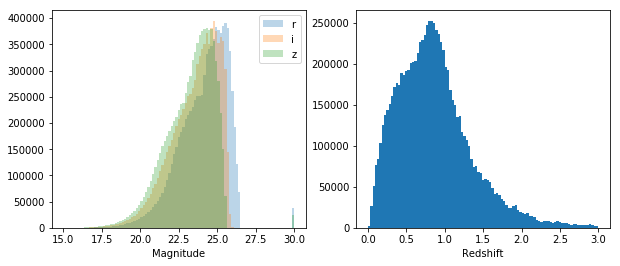

In [8]:
def plot_train():
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for band, idx in zip(bands, (0, 1, 2)):
        ax[0].hist(train_data_arr[:, idx], bins=np.linspace(15, 30, 100), label=band, alpha=0.3)
    ax[0].legend()
    ax[0].set_xlabel('Magnitude')
    ax[1].hist(training_z, bins=np.linspace(0, 3, 100))
    ax[1].set_xlabel('Redshift')
    
plot_train()

Load the validation data:

In [9]:
validation_file=f'/media/data2/tomo_challenge_data/ugrizy/validation.hdf5'
valid_data_arr = tc.load_data(validation_file, bands, 
                              errors=include_errors,
                              colors=include_errors, array=True)
val_z = tc.load_redshift(validation_file)
print(f'Loaded {len(valid_data_arr)} validation rows.')

Loaded 17228554 validation rows.


## Random Forest Example

In [10]:
nbins_rf = 4
ntrain_rf = 20000
nvalid_rf = 50000

In [11]:
classifier = tc.Tomographer._find_subclass('RandomForest')(bands, {'bins': nbins_rf})

In [12]:
classifier.train(train_data_arr[:ntrain_rf], training_z[:ntrain_rf])

Finding bins for training data
Fitting classifier


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [16]:
results = classifier.apply(valid_data_arr[:nvalid_rf])
z_rf = val_z[:nvalid_rf]

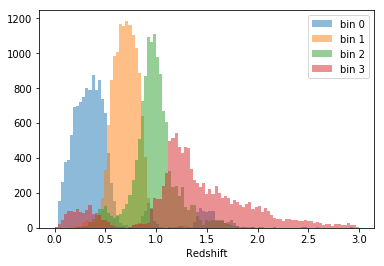

In [17]:
def plot_rf_bins():
    zbins = np.linspace(0, 3, 100)
    for bin in range(nbins_rf):
        plt.hist(z_rf[results == bin], zbins, alpha=0.5, label=f'bin {bin}')
    plt.legend()
    plt.xlabel('Redshift')
    
plot_rf_bins()

In [19]:
%time scores_rf = tc.jc_compute_scores(results, z_rf, metrics='all') #['SNR_3x2', 'FOM_3x2', 'FOM_DETF_3x2'])

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 3min 2s, sys: 21.5 s, total: 3min 24s
Wall time: 3min 40s


In [20]:
scores_rf

{'SNR_ww': 347.01068115234375,
 'FOM_ww': 25.575666427612305,
 'FOM_DETF_ww': 0.7120426297187805,
 'SNR_gg': 1172.628173828125,
 'FOM_gg': 608.364013671875,
 'FOM_DETF_gg': 6.4218525886535645,
 'SNR_3x2': 1174.98095703125,
 'FOM_3x2': 2074.23828125,
 'FOM_DETF_3x2': 48.22594451904297}

## Jax-Cosmo Calculations

Define the fiducial cosmology and ell binning:

In [39]:
cosmo = jc.Cosmology(
    Omega_c = 0.27,
    Omega_b = 0.045,
    h = 0.67,
    n_s = 0.96,
    sigma8 = 0.8404844953840714,
    Omega_k=0.,
    w0=-1., wa=0.)

In [41]:
ell, _ = tc.jax_metrics.ell_binning()

Calculate $\mu$ and $C$ for the random-forest results:

In [52]:
tomo_bin = jax.nn.one_hot(results, results.max() + 1)
probes = tc.jax_metrics.get_probes(tomo_bin, val_z[:nvalidate], what='3x2')

In [53]:
%time mu, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes, f_sky=0.25, nonlinear_fn=jc.power.halofit, sparse=True)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 7.57 s, sys: 1.34 s, total: 8.91 s
Wall time: 10.8 s


In [58]:
mu.shape, C.shape, sparse.is_sparse(C)

((3600,), (36, 36, 100), True)

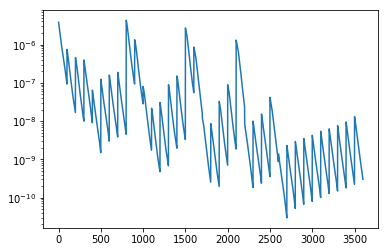

In [55]:
plt.semilogy(mu, '-');

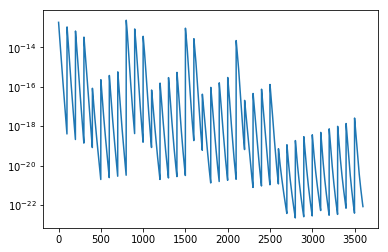

In [63]:
plt.semilogy(np.diag(sparse.to_dense(C)), '-');

## Formalism

Each combination, indexed by $i$, of a probe P_i (WL, number density, etc) and a redshift bin with normalized density $dn_i/dz(z)$ has an associated kernel function $K_i(a, \ell)$. The power spectrum associated with the pair $(i,j)$ is:
$$
c_{i,j}(\ell) = \frac{1}{c^2} \int_0^1 da K_i(a, \ell) K_j(a, \ell) F(a, \ell)
$$
where $F$ depends on the assumed cosmology but not on $i$ or $j$:
$$
F(a, \ell) = P_{NL}\left(\frac{\ell + 1/2}{\chi(a)}, a\right) \frac{1}{\chi(a)^2} \frac{d\chi}{da}(a) \; .
$$

The kernel is linear in the normalized density so if we combine two redshift bins $a + b \rightarrow ab$ according to
$$
\frac{dn_{ab}}{dz}(z) = \alpha \frac{dn_{a}}{dz}x(z) + \beta \frac{dn_{b}}{dz}(z) \; ,
$$
with $\alpha + \beta = 1$, then
$$
K_{ab}(a, \ell) = \alpha K_a(a, \ell) + \beta K_b(a, \ell)
$$
and
$$
c_{ab,j}(\ell) = \frac{1}{c^2} \int_0^1 da \left[ \alpha K_a(a, \ell) + \beta K_b(a, \ell) \right] K_j(a, \ell) F(a, \ell)
= \alpha c_{a,j}(\ell) + \beta c_{b,j}(\ell) \; .
$$

More generally, suppose we define new redshift bins for each probe that are linear combinations of the original redshift bins (for the same probe):
$$
\frac{dn'_i}{dz} = \left. \sum_j M_{ij} \frac{dn_j}{dz} \middle/ \sum_j M_{ij} \right. = \sum_j \tilde{M}_{ij} \frac{dn_j}{dz}
$$
with
$$
\tilde{M}_{ij} \equiv \frac{M_{ij}}{\sum_p M_{ip}} \; .
$$

then, in matrix notation,
$$
\mathbf{K}'(a, \ell) = \tilde{M}\cdot \mathbf{K}(a, \ell)
$$
and
$$
\mathbf{c}'(\ell) = \frac{1}{c^2} \int_0^1 da
\left[ \tilde{M}\cdot \mathbf{K}(a, \ell) \right]
\left[ \tilde{M}\cdot \mathbf{K}(a, \ell) \right]^T F(a, \ell)
= \tilde{M}\cdot \mathbf{c}(\ell) \cdot \tilde{M}^T \; .
$$

Note that the matrix $M$ is block diagonal, with blocks corresponding to each probe, since the new bins do not mix probes.

## Slice Redshift Bins

Define a redshift bin that is a slice of a Smail distribution with hard edges:

In [30]:
from jax.scipy.special import erf, gammaln, gammaincc

In [32]:
@jax.tree_util.register_pytree_node_class
class slice_nz(jc.redshift.redshift_distribution):
    """Defines a slice of a Smail distribution.
    
    The overall distribution shape is configured by (a,b,z0) and
    its overall normalization is configured by gals_per_arcmin2.
    The particular slice to use is specified by (zlo,zhi).
    Only (zlo,zhi) are used in gradient calculations.
    zmax is used to set the upper limit for numerical c_ell integrations
    and should be set equal to the largest slide upper limit.
    """
    def __init__(self, zlo, zhi, a, b, z0, gals_per_arcmin2, zmax):
        ##assert zlo < zhi and zlo >= 0 and zhi <= zmax
        # Calculate the integral of z ** a * exp(-((z / z0) ** b))
        r = (a + 1) / b
        G = jnp.exp(gammaln(r))
        integral = z0 ** (a + 1) / b * G
        # Calculate the fraction of galaxies in [zlo,zhi] relative to [0,infty].
        slice_frac = gammaincc(r, (zlo / z0) ** b) - gammaincc(r, (zhi / z0) ** b)
        # Initialize our base class. Variables to use for autograd must be
        # passed via *args and all others via **kwargs.
        super(slice_nz, self).__init__(
            zlo, zhi, # autograd variables
            a=a, b=b, z0=z0, # other config we need
            gals_per_arcmin2=gals_per_arcmin2 * slice_frac, zmax=zmax # base-class config
        )
        # Do not perform numerical normalization.
        self._norm_factor = gals_per_arcmin2 / integral
        self._norm = 1 / slice_frac
    
    def pz_fn(self, z):
        """Evaluate the galaxy density dn/dz in this slice.
        """
        zlo, zhi = self.params
        a, b, z0 = self.config['a'], self.config['b'], self.config['z0']
        locut = (1 + jnp.sign(z - zlo)) / 2
        hicut = (1 - jnp.sign(z - zhi)) / 2
        return z ** a * jnp.exp(-((z / z0) ** b)) * locut * hicut * self._norm_factor

Generate probes using redshift slices. When using both `g` and `w`, the same slices are used for both.

In [35]:
def get_slice_probes(zedges, what='gg', sigma_e=0.26, gals_per_arcmin2=40, a=1, b=2, z0=1, zmax=2.5):
    
    # Add the fixed outer edges.
    zedges = jnp.concatenate((jnp.array([0.]), jnp.asarray(zedges), jnp.array([zmax])))
    nzbins = len(zedges) - 1
    
    # Build the redshift bins.
    zbins = []
    for i in range(nzbins):
        zbin = slice_nz(
            zedges[i], zedges[i + 1],
            a=a, b=b, z0=z0,
            gals_per_arcmin2=gals_per_arcmin2, zmax=zmax)
        zbins.append(zbin)
        
    probes = []
    # start with number counts
    if (what == 'gg' or what == '3x2'):
        # Define a bias parameterization
        bias = jc.bias.inverse_growth_linear_bias(1.)
        probes.append(jc.probes.NumberCounts(zbins, bias))

    if (what == 'ww' or what == '3x2'):
        probes.append(jc.probes.WeakLensing(zbins, sigma_e=sigma_e))

    return probes

In [49]:
P1 = get_slice_probes([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0])

In [37]:
P2 = get_slice_probes([0.5, 1.0, 1.5])

In [53]:
len(P1), len(P2)

(1, 1)

In [50]:
%time cl1 = jc.angular_cl.angular_cl(cosmo, ell, P1)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 7.8 s, sys: 756 ms, total: 8.55 s
Wall time: 9.34 s


In [43]:
%time cl2 = jc.angular_cl.angular_cl(cosmo, ell, P2)

CPU times: user 7.02 s, sys: 760 ms, total: 7.79 s
Wall time: 8.4 s


In [51]:
cl1.shape, cl2.shape

((36, 100), (10, 100))

In [45]:
7 * 15, cl1.shape

(105, (28, 100))

In [54]:
[pz.gals_per_steradian for pz in P1[0].params[0]]

[DeviceArray(28640902., dtype=float32),
 DeviceArray(75925270., dtype=float32),
 DeviceArray(98807850., dtype=float32),
 DeviceArray(95444600., dtype=float32),
 DeviceArray(74817140., dtype=float32),
 DeviceArray(49263600., dtype=float32),
 DeviceArray(41166510., dtype=float32),
 DeviceArray(7745672., dtype=float32)]

In [55]:
[pz.gals_per_steradian for pz in P2[0].params[0]]

[DeviceArray(1.0456618e+08, dtype=float32),
 DeviceArray(1.9425245e+08, dtype=float32),
 DeviceArray(1.2408074e+08, dtype=float32),
 DeviceArray(48912184., dtype=float32)]

In [65]:
def reweighted_angular_cl(probes, cl, weights):
    # Include the relative normalizations of each original zbin.
    weights = jnp.asarray(weights)
    nout, nin = weights.shape
    ngal = jnp.array([[pz.gals_per_steradian for pz in probe.params[0]] for probe in probes])
    print(nin, nout, ngal.shape)
    M = weights * ngal.reshape(-1)
    M /= jnp.sum(M, axis=1, keepdims=True)
    print(np.round(np.array(M), 4))
    # Expand the cl vector into a symmetric array.
    ncl, nell = cl.shape
    assert ncl == (nin * (nin + 1)) // 2
    old_cl = np.empty((nin, nin, nell))
    idx = 0
    for i1 in range(nin):
        for i2 in range(i1, nin):
            old_cl[i1, i2] = np.array(cl[idx])
            if i2 > i1:
                old_cl[i2, i1] = old_cl[i1, i2]
            idx += 1
    old_cl = jnp.array(old_cl)
    new_cl = jnp.einsum('ij,')
    new_cl = jnp.dot(M, jnp.dot(old_cl, M.T))
    return new_cl

cl12 = reweighted_angular_cl(P1, cl1, [[1,1,0,0,0,0,0,0], [0,0,1,1,0,0,0,0], [0,0,0,0,1,1,0,0], [0,0,0,0,0,0,1,1]])

8 4 (1, 8)
[[0.2739 0.7261 0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.5087 0.4913 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.603  0.397  0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.8416 0.1584]]


TypeError: dot_general requires contracting dimensions to have the same shape, got [100] and [8].